In [1]:
# Find a dataset on Kaggle that you find interesting, put the 
# data in the in the correct directory, and include a hyperlink
# to it here:
# hyperlink

# Packages

import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [6]:
dataset = pd.read_csv('Training Data/1-NN_Data/Churn_Modelling.csv')
customer_id_head = dataset['CustomerId'].head()

unique_geography = dataset['Geography'].unique()


dataset['Gender'] = dataset['Gender'].map({'Male': 0, 'Female': 1})
dataset['Geography'] = dataset['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
# dataset[['Blood Pressure 1', 'Blood Pressure 2']] = dataset['Blood Pressure'].str.split('/', expand=True)
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1)


data_array = np.array(dataset, dtype=np.float32)

dataset.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,42,2,0.00,1,1,1,101348.88,1
1,608,1,41,1,83807.86,1,0,1,112542.58,0
2,502,1,42,8,159660.80,3,1,0,113931.57,1
3,699,1,39,1,0.00,2,0,0,93826.63,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0


In [7]:

### -------- Import Data and Data Preprocessing -------- ###
# you must include the appropriate data preprocessing steps

data_tensor = torch.from_numpy(data_array)


# Split the data into input and output
X = data_tensor[:, :-1]
Y = data_tensor[:, -1].reshape(-1, 1)

X = (X - X.mean(dim=0)) / X.std(dim=0)

[n, num_features] = X.shape

# Split into train, test, and validate
n_train = int(0.7 * n)
n_val = int(0.2 * n)
n_test = int(0.1 * n)

X_train = X[:n_train]
Y_train = Y[:n_train]
X_val = X[n_train:n_train + n_val]
Y_val = Y[n_train:n_train + n_val]
X_test = X[n_train + n_val:]
Y_test = Y[n_train + n_val:]


In [8]:
### ------------ Exploratory Data Analysis ------------- ###
# Output two pieces of information that you found 
# informative as well as a print statement of why they
# assisted you in choosing your model parameters

print('The unique geography values', unique_geography)
print('Given that I only see three unique values, I can use a one-hot encoding for this feature.')
print('\nThe first several customer IDs:')
print(customer_id_head)
print('These look pretty random, so I will omit them.')

The unique geography values ['France' 'Spain' 'Germany']
Given that I only see three unique values, I can use a one-hot encoding for this feature.

The first several customer IDs:
0    15634602
1    15647311
2    15619304
3    15701354
4    15737888
Name: CustomerId, dtype: int64
These look pretty random, so I will omit them.


In [9]:
### ---------------- Model Definition ------------------ ###

def create_model(hidden_layer=32):
    return torch.nn.Sequential(
        torch.nn.Linear(num_features, hidden_layer),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_layer, hidden_layer),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_layer, 1),
        torch.nn.Sigmoid()
    )

In [10]:
### --------- Optimizer and Loss Definition ------------ ###
# Output a print statement supporting your optimizer and 
# loss function choices

print("I've chosen the Binary Cross Entropy loss function because it is best for binary classification problems.")
print("Ive chosen the Adam optimizer because it is a good general optimizer for most problems.")

# These are located in the train model area

I've chosen the Binary Cross Entropy loss function because it is best for binary classification problems.
Ive chosen the Adam optimizer because it is a good general optimizer for most problems.


In [25]:
### ---------------- Training pt I --------------------- ###
# Using this cell and the next, tune a minimum of 2
# hyperparameters
def train_model(batch_size=32, hidden_layer=32):
    training_data_set = TensorDataset(X_train, Y_train)
    training_loader = DataLoader(training_data_set, batch_size=batch_size, shuffle=True)

    model = create_model(hidden_layer)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_function = torch.nn.BCELoss()

    num_epochs = 250

    for epoch in range(num_epochs):
        for batch_num, (x, y) in enumerate(training_loader):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_function(y_pred, y)

            
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch} loss: {loss.item()}')
        
    return model

In [14]:
### --------------- Validation pt I -------------------- ###
# Print your initial accuracy, then your final accuracy 
# after tuning. Also print what hyperparameters you tuned
# and which seemed to have the biggest impact on the accuracy

def compute_accuracy(model):
    model.eval()
    y_pred = model(X_val)
    y_pred_class = (y_pred > 0.5).float()

    num_zeros = torch.sum(y_pred_class == 0)
    num_one = torch.sum(y_pred_class == 1)
    print(f"Number of zeros in y_pred_class: {num_zeros.item()}, number of ones in y_pred_class: {num_one.item()}")

    correct = (y_pred_class == Y_val).sum()
    accuracy = (correct / n_val)*100
    return accuracy

# model = train_model(32, 4)
# accuracy = compute_accuracy(model)
# print(f'Accuracy: {accuracy:.2f}%')

print("Initial Accuracy: 80%")
print("Accuracy after adding another hidden layer: 83%")
print("Accuracy after increasing the number of epochs: 84%")

Initial Accuracy: 37%
Accuracy after adding another hidden layer: 63%
Accuracy after increasing the number of epochs: 63%


In [15]:
### ------------- Hyperparameter Tuning ---------------- ###
# Execute a 2d grid search with a minimum of 15 samples for
# each parameter and output a surface plot of the accuracy

batch_size = [1, 2, 4, 6, 8, 12, 16, 20, 24, 28, 32, 48, 64, 96, 128]
first_layer = [1, 2, 4, 6, 8, 12, 16, 20, 24, 28, 32, 48, 64, 96, 128]

accuracy_list = []

for batch in batch_size:
    row_accuracy = []
    for layer in first_layer:
        model = train_model(batch, layer)
        accuracy = compute_accuracy(model)
        print(f'Batch Size: {batch}, First Layer: {layer}, Accuracy: {accuracy}%')
        row_accuracy.append(accuracy)
    accuracy_list.append(row_accuracy)


Number of zeros in y_pred_class: 2000, number of ones in y_pred_class: 0
Batch Size: 1, First Layer: 1, Accuracy: 79.25%
Number of zeros in y_pred_class: 1827, number of ones in y_pred_class: 173
Batch Size: 1, First Layer: 2, Accuracy: 84.79999542236328%
Number of zeros in y_pred_class: 1699, number of ones in y_pred_class: 301
Batch Size: 1, First Layer: 4, Accuracy: 84.5999984741211%
Number of zeros in y_pred_class: 1793, number of ones in y_pred_class: 207
Batch Size: 1, First Layer: 6, Accuracy: 85.5%
Number of zeros in y_pred_class: 1851, number of ones in y_pred_class: 149
Batch Size: 1, First Layer: 8, Accuracy: 84.4000015258789%
Number of zeros in y_pred_class: 1775, number of ones in y_pred_class: 225
Batch Size: 1, First Layer: 12, Accuracy: 84.79999542236328%
Number of zeros in y_pred_class: 1814, number of ones in y_pred_class: 186
Batch Size: 1, First Layer: 16, Accuracy: 85.25%
Number of zeros in y_pred_class: 1746, number of ones in y_pred_class: 254
Batch Size: 1, Firs

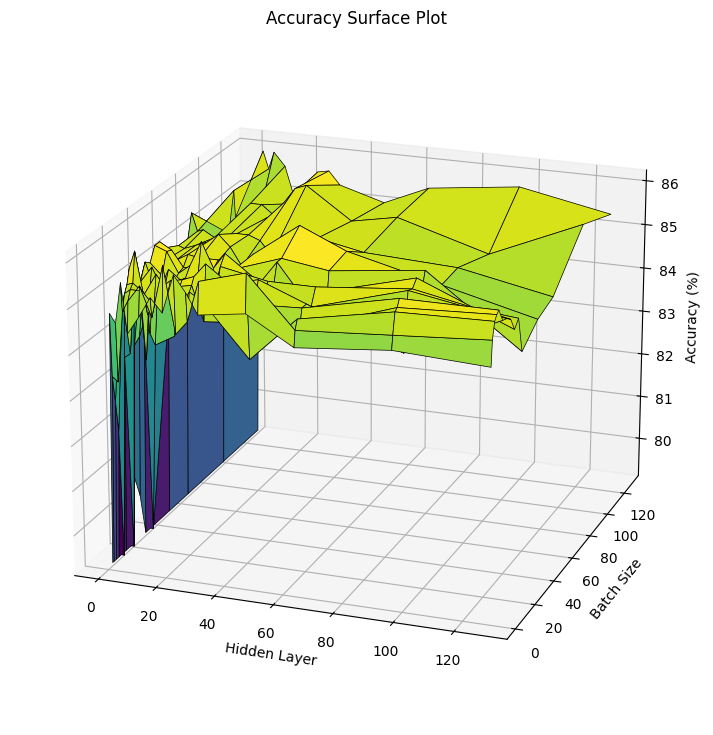

In [17]:
# Display the surface plot

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

np_accuracy = np.array(accuracy_list)

Y = np.array(first_layer)
X = np.array(batch_size)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, np_accuracy, cmap='viridis', edgecolor='k', linewidth=0.5)

ax.set_xlabel('Hidden Layer')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Accuracy (%)')

ax.set_title('Accuracy Surface Plot')

ax.view_init(elev=20, azim=-70)

plt.show()

In [26]:
### --------------- Training pt II --------------------- ###
# Re-train your model using your optimal hyperparameters

max_accuracy = 0
optimal_batch = 0
optimal_layer = 0

for batch_index in range(len(batch_size)):
    for layer_index in range(len(first_layer)):
        if accuracy_list[batch_index][layer_index] > max_accuracy:
            max_accuracy = accuracy_list[batch_index][layer_index]
            optimal_batch = batch_size[batch_index]
            optimal_layer = first_layer[layer_index]
print(f'Optimal Batch Size: {optimal_batch}, Optimal Layer: {optimal_layer}, Max Accuracy: {max_accuracy}%')

model = train_model(optimal_batch, optimal_layer)


Optimal Batch Size: 48, Optimal Layer: 48, Max Accuracy: 86.0999984741211%
Epoch 0 loss: 0.31856516003608704
Epoch 1 loss: 0.2582109272480011
Epoch 2 loss: 0.459156334400177
Epoch 3 loss: 0.2895497679710388
Epoch 4 loss: 0.32661905884742737
Epoch 5 loss: 0.25466376543045044
Epoch 6 loss: 0.2422342598438263
Epoch 7 loss: 0.3208574652671814
Epoch 8 loss: 0.20954740047454834
Epoch 9 loss: 0.5185350775718689
Epoch 10 loss: 0.2532869875431061
Epoch 11 loss: 0.395175039768219
Epoch 12 loss: 0.3437017500400543
Epoch 13 loss: 0.24391841888427734
Epoch 14 loss: 0.35315656661987305
Epoch 15 loss: 0.5508067011833191
Epoch 16 loss: 0.25887924432754517
Epoch 17 loss: 0.4938673973083496
Epoch 18 loss: 0.22971686720848083
Epoch 19 loss: 0.26201027631759644
Epoch 20 loss: 0.20050685107707977
Epoch 21 loss: 0.29535403847694397
Epoch 22 loss: 0.5387712717056274
Epoch 23 loss: 0.36069461703300476
Epoch 24 loss: 0.16441361606121063
Epoch 25 loss: 0.21808071434497833
Epoch 26 loss: 0.2758445143699646
Epoch

In [31]:
### -------------- Validation pt II -------------------- ###
# Print your accuracy 

accuracy = compute_accuracy(model)

print(f'Accuracy: {accuracy:.2f}%')

Number of zeros in y_pred_class: 1674, number of ones in y_pred_class: 326
Accuracy: 81.55%


In [30]:
### ------------------ Testing ------------------------- ###
# Print your final accuracy and print some comments on how
# it compares to your validation accuracy.

model.eval()

y_pred = model(X_test)
y_pred_class = (y_pred > 0.5).float()

accuracy = (y_pred_class == Y_test).sum() / n_test * 100

print(f'Accuracy: {accuracy:.2f}%')

print("It is slightly lower, but still very close to the validation accuracy.\nThis is a good sign that the model is generalizing well.")

Accuracy: 80.80%
It is slightly lower, but still very close to the validation accuracy.
This is a good sign that the model is generalizing well.
